In [1]:
#Imports
import pickle
import numpy as np
import os 
import matplotlib.pyplot as plt


# Load data functions
# Functions from Cifar page
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def loadLabels(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        return [x.decode('ascii') for x in data[b'label_names']]
    
def intToLabel(a):
    strs = ["" for x in range(len(a))]
    for i in range(len(a)):
        strs[i] = labels[a[i]]
    return strs
    
def batchToObject(batch):
    
    convertToText = np.transpose(np.array(batch[b'labels']))
    for i in range(len(batch[b'labels'])):
        zeroVector = np.zeros((10,1))
        zeroVector[batch[b'labels'][i]] = 1
        batch[b'labels'][i] = np.transpose(zeroVector)[0].astype(int)
    # Create new dictionaries
    batchAsObject =  {
        'images': np.divide(batch[b'data'], 255),
        'label':  np.array(batch[b'labels']),
        'labelText': intToLabel(convertToText)
    }
    return batchAsObject

In [351]:
# Destination to dataset
dataDir = "C:/Users/ottarg/Desktop/KTH_PROGRAM/4-Deep Learning/Assignments/DataSets"

# Load labels
labelDir = dataDir + "/batches.meta"
labels = loadLabels(labelDir)

# Advanced parameters for optimization
TRAIN_ALL_DATA = False

if(TRAIN_ALL_DATA):
    training1 = batchToObject(unpickle(dataDir + "/data_batch_1"))
    training2 = batchToObject(unpickle(dataDir + "/data_batch_2"))
    training3 = batchToObject(unpickle(dataDir + "/data_batch_3"))
    training4 = batchToObject(unpickle(dataDir + "/data_batch_4"))
    training5 = batchToObject(unpickle(dataDir + "/data_batch_5"))
    
    # lenOfBatch
    lb = 10000
    #restForVali
    rV = 200
    #sliceIndex
    sl = lb- rV
    training = {
        'images': np.vstack((training1['images'][0:sl], training2['images'][0:sl], training3['images'][0:sl], training4['images'][0:sl], training5['images'][0:sl])) ,
        'label': np.vstack((training1['label'][0:sl], training2['label'][0:sl], training3['label'][0:sl], training4['label'][0:sl], training5['label'][0:sl])) ,
        'labelText': np.vstack((training1['labelText'][0:sl], training2['labelText'][0:sl], training3['labelText'][0:sl], training4['labelText'][0:sl], training5['labelText'][0:sl])) ,
    }
    validate = {
        'images': np.vstack((training1['images'][sl:lb], training2['images'][sl:lb], training3['images'][sl:lb], training4['images'][sl:lb], training5['images'][sl:lb])) ,
        'label': np.vstack((training1['label'][sl:lb], training2['label'][sl:lb], training3['label'][sl:lb], training4['label'][sl:lb], training5['label'][sl:lb])) ,
        'labelText': np.vstack((training1['labelText'][sl:lb], training2['labelText'][sl:lb], training3['labelText'][sl:lb], training4['labelText'][sl:lb], training5['labelText'][sl:lb])) ,
    }
    
    
else:    
    training = batchToObject(unpickle(dataDir + "/data_batch_1"))
    validate = batchToObject(unpickle(dataDir + "/data_batch_2"))

testing = batchToObject(unpickle(dataDir + "/test_batch"))

train_meanVal = np.mean(np.transpose(training['images']), axis=1)

def calculateBatchNormalize(inputData,meanv):

    nData = np.shape(inputData)[0]
    ones = np.eye(nData,nData)
    
    fir = np.transpose(np.transpose(inputData) - meanv)
    return np.transpose(np.dot(ones, fir))

# You should only compute the mean for the training data and then
# keep a record of this mean and subtract it from the input vectors in the validation and test sets.
training['images'] = calculateBatchNormalize(np.transpose(training['images']), train_meanVal)
validate['images'] = calculateBatchNormalize(np.transpose(validate['images']), train_meanVal)
testing['images']  = calculateBatchNormalize(np.transpose(testing['images']) , train_meanVal)



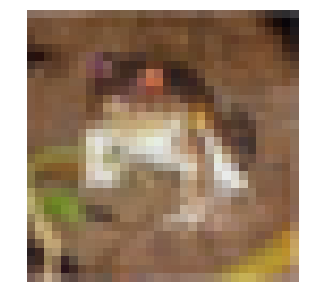

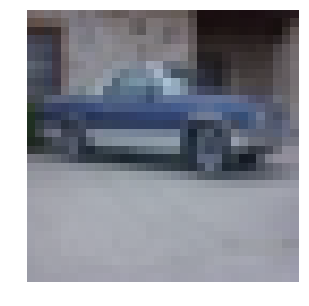

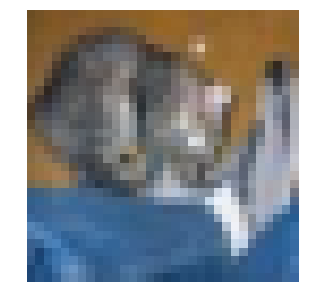

In [268]:
# Draw the edited data
def dispImg(img, label):
    # ‘F’ means to read / write the elements using Fortran-like index order, 
    # with the first index changing fastest, and the last index changing slowest.
    loadImg = np.reshape(img, (32, 32, 3), order='F') 
    rotImg = np.rot90(loadImg, k=3) # change to 3 times?
    plt.rcParams["figure.figsize"] = [5,5]
    plt.imshow(rotImg)
    plt.axis('off')
    plt.title(label)

def plotManyImg(dataset,n,m):
    imgNo = 0
    for i in range(n*m): 
        plt.subplot(n, m, i+1)
        dispImg(dataset['images'][i], dataset['labelText'][i])
    plt.show()

def plotNormalizedSet(normSet,n,m):
    imgNo = 0
    for i in range(n*m): 
        plt.subplot(n, m, i+1)
        dispImg(normSet[i], "")
    plt.show()

def normalize(weightMatrix):
    maxVal = np.max(weightMatrix)
    minVal = np.min(weightMatrix)
    return (weightMatrix - minVal) / (maxVal - minVal)    
    
normTrain = normalize(np.transpose(training['images']))
normValid = normalize(np.transpose(validate['images']))
normTest = normalize(np.transpose(testing['images']))
    
# Plot the batch normalized images
plotNormalizedSet(np.transpose(normTrain)[0:1],1,1)
plotNormalizedSet(np.transpose(normValid)[0:1],1,1)
plotNormalizedSet(np.transpose(normTest)[0:1],1,1)


In [372]:
# Helping functions

# Softmax function
    def softmaxForward(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def reluForward(x):
    return x * (x > 0)

def batchForward(x, computingCost, avgMean, avgVar, flag):
    
    # You should use these moving averages
    #when you compute the cost and accuracy on the training and validation sets
    #after each epoch.
    if(computingCost):
        mean = avgMean
        var = avgVar
    else:
        mean = np.mean(x,axis=1, keepdims=True)
        var =  np.var(x,axis=1, keepdims=True)
        alpha = 0.99
        # used to set the first inital avgMean
        if(flag == False):
            avgMean  = mean
            avgVar = var
            flag = True
        
        avgMean = (1 - alpha) * mean + alpha * avgMean 
        avgVar = (1 - alpha) * var + alpha * avgVar 
    
    return pow(var, -0.5) * (x - mean), mean, var, x, avgMean, avgVar, flag

# Cross entropy
def crossEntropy(X):
    m = len(X)
    logLikelihood = -np.log(X)
    loss = np.sum(logLikelihood) / m
    return loss

# Calculating functions
def evaluateClassifier(inputData, weights, bias, h_weights, h_bias):
    # Calculate the softmax with dot product of weights and input
    calc1 = calculateLayerForward(inputData, inputWeights, inputBias)
    relu1 = reluForward(calc1)
    calc2 = calculateLayerForward(relu1, h_weights, h_bias)
    softmax2 = softmaxForward(calc2)
    return softmax2

# Returns the net outcome 
def calculateLayerForward(inputData,weights, bias):
    # Calculate the softmax with dot product of weights and input
    calculateNetwork = np.dot(weights, inputData) + bias
    return calculateNetwork


def computeCost(probab, realLabel, weights, lambdaVal):
    winValue = np.multiply(realLabel, probab)
    sumValue = winValue.sum(axis=0)
    # Calculate cross-entropy loss
    # Add regularization
    regularization = lambdaVal * np.sum(np.power(weights, 2))
    crossEntropyLoss = crossEntropy(sumValue) + regularization
    return  crossEntropyLoss

def computeAccuracy(probab, realLabel):
    # Get the index of the real class
    # Select the winning(max value) index of each array
    predict = np.argmax(probab, axis=0)
    realLabel = np.argmax(realLabel, axis=0)
    # Count how many were actually correctly classified
    percOfCorrectlyClassified = (np.sum(predict == realLabel)) / len(realLabel)
    # Divide by number of elements to get percentage
    return percOfCorrectlyClassified 


In [363]:
# Functions for calculating the gradients

def calculateGradient(inputData, probab, realLabel, weights, bias, lambdaVal):
    # Set all entries in @L/@b and @L/@W to zero.
    weightsGradient = np.zeros((np.shape(weights)[0],np.shape(weights)[1]))
    biasGradient = np.zeros((np.shape(bias)[0],np.shape(bias)[1]))
    
    gradients = []
    
    N = np.shape(realLabel)[1]
    for i in range(N):
        # Evaluate p - already have it
        pVal = probab[:, i]
        # X
        inputX = inputData[:, i]
        # y
        target = realLabel[:,i]
        # Let
        gradVal = pVal - target
        gradients.append(gradVal)
        # Add gradient of l(x; y;W; b) w.r.t. b
        biasGradient += np.reshape(gradVal, np.shape(biasGradient))
        # Add gradient of l(x; y;W; b) w.r.t. W:
        weightsGradient += np.outer(gradVal, inputX)

    # Add regularization
    regularization = 2 * lambdaVal * weights
    # Add the gradient for the regularization term
    weightsGradient = (weightsGradient / N) + regularization
    biasGradient = biasGradient / N
    
    gradientChange = np.dot(gradients, weights)
    return weightsGradient, biasGradient, gradientChange

                       
def calculateGradientRelu(inputData, probab, realLabel, weights, bias, lambdaVal):


    weightsGradient = np.zeros((np.shape(weights)[0],np.shape(weights)[1]))
    biasGradient = np.zeros((np.shape(bias)[0],np.shape(bias)[1]))
    
    gradients = []
    N = np.shape(probab)[1]
    
    gradVal = np.multiply(realLabel, np.transpose(probab) > 0)
    for i in range(N):
        inputX = inputData[:, i]
        grad = gradVal[i, :]
        
        gradients.append(grad)
        # Add gradient of l(x; y;W; b) w.r.t. b
        
        biasGradient += np.reshape(grad, np.shape(biasGradient))
        # Add gradient of l(x; y;W; b) w.r.t. W:
        weightsGradient += np.outer(grad, inputX)
    
    # Add regularization
    regularization = 2 * lambdaVal * weights
    # Add the gradient for the regularization term
    weightsGradient = (weightsGradient / N) + regularization
    biasGradient = biasGradient / N
    
    # NOTE: 
    # The gradients for two layer network is not needed but should be here if the network was stacked using more layers
    # This sure came in handy here :)
    gradientChange = np.dot(gradients, weights)
    return weightsGradient, biasGradient, gradientChange, gradVal

def calculateGradientBatch(gradVal, mean, var, data):
    N = np.shape(data)[1]
    
    # HMM - there was no function at the last slide of lecture 4.
    # But - I helped myself out and found this niche tutorial on how to implement it 
    # https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html
    # I hope this is okay, since I read though this tutorial and managed to implement it in my code.
    gradients = np.transpose(gradVal)
    derivSqr = pow(var, -0.5)
    xModif = data - mean
    
    derivVar = (pow(var, -1.5)) * -1
    derivVar *= np.sum(gradients * xModif, axis=1, keepdims=True)
    dX = derivSqr * np.sum(gradients, axis=1, keepdims=True) * -1

    # Gradient computations
    gradients = (gradients * derivSqr) + (derivVar * xModif / N) + (dX / N)
    return np.transpose(gradients)


In [373]:
import math

np.random.seed(5)

n = 10 # First 50 images
inputData = np.transpose(training['images'][0:n])
realLabel = np.transpose(training['label'][0:n])

class LayerObject(object):


    def __init__(self, layerType, nIn, nOut, useBN):
        self.layerType = layerType
        self.nIn = nIn
        self.nOut = nOut
        self.bn = useBN
        
        sigm = math.sqrt(2/nIn)
        variance = pow(sigm,2) 
        
        self.weights = np.random.normal(0.0, variance, (nOut, nIn))
        self.bias = np.random.normal(0.0, variance, (nOut, 1))
       
        self.weightsGradient = np.zeros((nOut, nIn))
        self.biasGradient = np.zeros((nOut, 1))
        
        self.weightMomentum = np.zeros((np.shape(self.weights)))
        self.biasMomentum = np.zeros((np.shape(self.bias)))

        # Keep track of variables in batch normalization
        # This should be it's own type of layer..
        self.bn_mean = 0;
        self.bn_var = 0;
        self.bn_data = np.zeros((nIn, 1))
        self.avgFlag = False
        self.bn_avgMean = 0;
        self.bn_avgVar = 0;
        
    def forwardCalc(self,inputData, computingCost):
        calcLayer = calculateLayerForward(inputData, self.weights , self.bias )
        if(self.layerType=="RELU"):
            if(self.bn):

                calcLayer, currMean, currVar, currData, currAvgMean, currAvgVar, flag = batchForward(calcLayer, computingCost, self.bn_avgMean, self.bn_avgVar, self.avgFlag)
                self.bn_mean = currMean;
                self.bn_var = currVar
                self.bn_data = currData
                self.bn_avgMean = currAvgMean;
                self.bn_avgVar = currAvgVar;
                self.avgFlag = flag;
            activation = reluForward(calcLayer)
        elif(self.layerType=="SOFTMAX"):
            activation = softmaxForward(calcLayer)
            
        return activation
    
    def gradient(self,inp, out, target, lamdbaVal):
        
        if(self.layerType=="RELU"):
            self.weightsGradient, self.biasGradient, gradTarget, gradVal = calculateGradientRelu(inp, out, target, self.weights, self.bias, lamdbaVal)
            if(self.bn):
                bnGrads = calculateGradientBatch(gradVal, self.bn_mean, self.bn_var, self.bn_data)
                gradTarget = np.dot(bnGrads, self.weights)
            
        elif(self.layerType=="SOFTMAX"):
            self.weightsGradient, self.biasGradient, gradTarget = calculateGradient(inp, out, target, self.weights, self.bias, lamdbaVal)

        return gradTarget;
    
    def update(self, eta, mom ):
        self.weightMomentum = mom * self.weightMomentum + eta * self.weightsGradient
        self.biasMomentum = mom * self.biasMomentum + eta * self.biasGradient
        
        self.weights -= self.weightMomentum
        self.bias -= self.biasMomentum
    
class Network(object):
    def __init__(self, eta = 0.01, epoch=5, batch=500, lambdaVal = 0.000000, momentum= 0.9):
        
        self.layers = []
        self.nLayers = 0
        self.activations = []
        self.gradients = []
        
        # Values for training
        self.eta = eta
        self.epoch = epoch
        self.batch = batch
        self.lambdaVal = lambdaVal
        self.momentum = momentum
        self.startingEta = eta
        
        self.computingCost = False
    
    def networkInfo(self):
        return "Network Eta:" + str(self.startingEta) + " epoch: " + str(self.epoch) + " batch: " + str(self.batch)+ " lambdaVal: " + str(self.lambdaVal)+ " momentum: " + str(self.momentum)
    
    def putLayer(self, layer):
        self.layers.append(layer)
        self.nLayers += 1
        self.activations.append([])
        self.gradients.append([])

    
    def updateWeights(self):
        for i in range(self.nLayers):
            #print(i)
            self.layers[i].update(self.eta, self.momentum)
    
    def feedForwardEvaluate(self, myInputData, corrLabel):
        
        for i in range(self.nLayers):
            if(i == 0):
                act = self.layers[i].forwardCalc(myInputData, self.computingCost)
                self.activations[i] = act
            else:
                act = self.layers[i].forwardCalc(self.activations[i-1], self.computingCost)
                self.activations[i] = act

            if(i == self.nLayers-1):
                cost = computeCost(self.activations[i], corrLabel,  self.layers[i].weights, self.lambdaVal)
                acc = computeAccuracy(self.activations[i], corrLabel)
                return cost, acc
                

    def calcGradients(self,myInputData, myRealLabel):
        
        for i in reversed(range(self.nLayers)):
            if(i != 0):
                if(i == self.nLayers-1):
                    target = myRealLabel;
                else:
                    target = self.gradients[i+1]
                
                gradChange = self.layers[i].gradient(self.activations[i-1],self.activations[i],target, self.lambdaVal)
                self.gradients[i] = gradChange
            else:
                self.layers[i].gradient(myInputData,self.activations[i],self.gradients[i+1], self.lambdaVal)


    
myNetwork = Network();

myNetwork.putLayer(LayerObject("RELU",3072,50, True))
myNetwork.putLayer(LayerObject("RELU",50,30, True))
myNetwork.putLayer(LayerObject("SOFTMAX",30,10, False))
cost, acc = myNetwork.feedForwardEvaluate(inputData, realLabel)
print("Cost:",cost)
print("Accuracy:",acc)
myNetwork.calcGradients(inputData, realLabel)
myNetwork.updateWeights()

myNetwork.computingCost = True
cost, acc = myNetwork.feedForwardEvaluate(inputData, realLabel)
print("Cost:",cost)
print("Accuracy:",acc)

myNetwork.computingCost = False

cost, acc = myNetwork.feedForwardEvaluate(inputData, realLabel)

print("Cost:",cost)
print("Accuracy:",acc)
myNetwork.calcGradients(inputData, realLabel)
myNetwork.updateWeights()

#self


Cost: 2.29408185634
Accuracy: 0.0
Cost: 1.7377160553
Accuracy: 0.5
Cost: 1.99053089611
Accuracy: 0.4


In [161]:

TWO_LAYER = False
THREE_LAYER = True
FOUR_LAYER = True
# Here I'm checking if the network can successly do 1 simple epoch
np.random.seed(5)

inputNodes = 32*32*3 # 32*32*rgb
hiddenNodes = 50
outputNodes = 10

eta = 0
lambdaVal = 0.0
n = 100 # First 100 images
inputData = np.transpose(training['images'][0:n])
realLabel = np.transpose(training['label'][0:n])

if(TWO_LAYER):
    print("two")
    #First layer
    inputWeights = np.random.normal(0.0, 0.001, (50, inputNodes))
    inputBias = np.random.normal(0.0, 0.001, (50, 1))

    #Hidden layer 1
    hiddenWeights1 = np.random.normal(0.0, 0.001, (10, 50))
    hiddenBias1 = np.random.normal(0.0, 0.001, (10, 1))
    
    calc1 = calculateLayerForward(inputData, inputWeights, inputBias)
    relu1 = reluForward(calc1)

    calc2 = calculateLayerForward(relu1, hiddenWeights1, hiddenBias1)
    softmax2 = softmaxForward(calc2)

    startingCost = computeCost(softmax2, realLabel,  hiddenWeights1, lambdaVal)
    hiddenWeightsGradient1, hiddenBiasGradient1, hiddenGradChange1 = calculateGradient(relu1, softmax2, realLabel, hiddenWeights1, hiddenBias1, lambdaVal)
    inputWeightsGradient, inputBiasGradient, inputGradChange = calculateGradientRelu(inputData, relu1, hiddenGradChange1, inputWeights, inputBias, lambdaVal)
    print("Done")
    
if(THREE_LAYER):
    #First layer
    print("Three")

    inputWeights = np.random.normal(0.0, 0.001, (50, inputNodes))
    inputBias = np.random.normal(0.0, 0.001, (50, 1))

    #Hidden layer 1
    hiddenWeights1 = np.random.normal(0.0, 0.001, (30, 50))
    hiddenBias1 = np.random.normal(0.0, 0.001, (30, 1))
    #Hidden layer 3
    hiddenWeights2 = np.random.normal(0.0, 0.001, (10, 30))
    hiddenBias2 = np.random.normal(0.0, 0.001, (10, 1))
    
    calc1 = calculateLayerForward(inputData, inputWeights, inputBias)
    relu1 = reluForward(calc1)

    calc2 = calculateLayerForward(relu1, hiddenWeights1, hiddenBias1)
    relu2 = reluForward(calc2)

    calc3 = calculateLayerForward(relu2, hiddenWeights2, hiddenBias2)
    softmax3 = softmaxForward(calc3)

    startingCost = computeCost(softmax3, realLabel,  hiddenWeights2, lambdaVal)
    hiddenWeightsGradient2, hiddenBiasGradient2, hiddenGradChange2 = calculateGradient(relu2, softmax3, realLabel, hiddenWeights2, hiddenBias2, lambdaVal)
    hiddenWeightsGradient1, hiddenBiasGradient1, hiddenGradChange1 = calculateGradientRelu(relu1, relu2, hiddenGradChange2, hiddenWeights1, hiddenBias1, lambdaVal)
    inputWeightsGradient, inputBiasGradient, inputGradChange = calculateGradientRelu(inputData, relu1, hiddenGradChange1, inputWeights, inputBias, lambdaVal)
    print("Done")
    
    
if(FOUR_LAYER):
    print("Four")
    inputWeights = np.random.normal(0.0, 0.001, (50, inputNodes))
    inputBias = np.random.normal(0.0, 0.001, (50, 1))

    #Hidden layer 1
    hiddenWeights1 = np.random.normal(0.0, 0.001, (30, 50))
    hiddenBias1 = np.random.normal(0.0, 0.001, (30, 1))
    #Hidden layer 3
    hiddenWeights2 = np.random.normal(0.0, 0.001, (20, 30))
    hiddenBias2 = np.random.normal(0.0, 0.001, (20, 1))
    
    hiddenWeights3 = np.random.normal(0.0, 0.001, (10, 20))
    hiddenBias3 = np.random.normal(0.0, 0.001, (10, 1))
    
    calc1 = calculateLayerForward(inputData, inputWeights, inputBias)
    relu1 = reluForward(calc1)

    calc2 = calculateLayerForward(relu1, hiddenWeights1, hiddenBias1)
    relu2 = reluForward(calc2)

    calc3 = calculateLayerForward(relu2, hiddenWeights2, hiddenBias2)
    relu3 = reluForward(calc3)
    
    calc4 = calculateLayerForward(relu3, hiddenWeights3, hiddenBias3)
    softmax4 = softmaxForward(calc4)

    startingCost = computeCost(softmax4, realLabel,  hiddenWeights3, lambdaVal)
    hiddenWeightsGradient3, hiddenBiasGradient3, hiddenGradChange3 = calculateGradient(relu3, softmax4, realLabel, hiddenWeights3, hiddenBias3, lambdaVal)

    hiddenWeightsGradient2, hiddenBiasGradient2, hiddenGradChange2 = calculateGradientRelu(relu2, relu3, hiddenGradChange3, hiddenWeights2, hiddenBias2, lambdaVal)
    
    hiddenWeightsGradient1, hiddenBiasGradient1, hiddenGradChange1 = calculateGradientRelu(relu1, relu2, hiddenGradChange2, hiddenWeights1, hiddenBias1, lambdaVal)
    inputWeightsGradient, inputBiasGradient, inputGradChange = calculateGradientRelu(inputData, relu1, hiddenGradChange1, inputWeights, inputBias, lambdaVal)
    print("Done")
    


if(True):
    # Changed this function to just simply calculate one weight matrix at a time
    def computeGradsNum(realLabel, inputData,
                                 weightInput, 
                                 totalCostInput,pos):
        # Initialize an empty matrix to contain the gradients
        gradients = np.zeros(np.shape(weightInput))
        h = 1e-5  
        
        print(np.shape(weightInput)[0])
        print(np.shape(weightInput)[1])

        for i in range(np.shape(weightInput)[0]):
            print(i)
            for j in range(np.shape(weightInput)[1]):
                weightInput[i, j] += h
                if(pos == "1W"):
                # Do the forward pass and get the final cost
                    calc1 = calculateLayerForward(inputData, weightInput, inputBias)
                elif(pos=="1B"):
                    calc1 = calculateLayerForward(inputData, inputWeights, weightInput)
                else:
                    calc1 = calculateLayerForward(inputData, inputWeights, inputBias)

                relu1 = reluForward(calc1)

                if(pos == "2W"):
                # Do the forward pass and get the final cost
                    calc2 = calculateLayerForward(relu1, weightInput, hiddenBias1)
                elif(pos=="2B"):
                    calc2 = calculateLayerForward(relu1, hiddenWeights1, weightInput)
                else:
                    calc2 = calculateLayerForward(relu1, hiddenWeights1, hiddenBias1)
                
                if(TWO_LAYER):
                    softmax2= softmaxForward(calc2)
                    totalCost2 = computeCost(softmax2, realLabel, hiddenWeights1, lambdaVal)
                    gradients[i, j] = (totalCost2 - totalCostInput) / h
                    weightInput[i, j] -= h
                    
                if(THREE_LAYER):
                    relu2 = reluForward(calc2)
                    if(pos == "3W"):
                    # Do the forward pass and get the final cost
                        calc3 = calculateLayerForward(relu2, weightInput, hiddenBias2)
                    elif(pos=="3B"):
                        calc3 = calculateLayerForward(relu2, hiddenWeights2, weightInput)
                    else:
                        calc3 = calculateLayerForward(relu2, hiddenWeights2, hiddenBias2)

                    #softmax3 = softmaxForward(calc3)
                    #totalCost2 = computeCost(softmax3, realLabel, hiddenWeights2, lambdaVal)
                    #gradients[i, j] = (totalCost2 - totalCostInput) / h
                    #weightInput[i, j] -= h
                    
                if(FOUR_LAYER):
                    relu3 = reluForward(calc3)
                    if(pos == "4W"):
                    # Do the forward pass and get the final cost
                        calc4 = calculateLayerForward(relu3, weightInput, hiddenBias3)
                    elif(pos=="4B"):
                        calc4 = calculateLayerForward(relu3, hiddenWeights3, weightInput)
                    else:
                        calc4 = calculateLayerForward(relu3, hiddenWeights3, hiddenBias3)

                    softmax4 = softmaxForward(calc4)
                    totalCost2 = computeCost(softmax4, realLabel, hiddenWeights3, lambdaVal)
                    gradients[i, j] = (totalCost2 - totalCostInput) / h
                    weightInput[i, j] -= h
                    
        return gradients


    #Compare them
    def compareDifferenation(infoString, weightsGradient, weightsGradientNum):
        minVal = 1e-6 

        # Compute the relative error of weights
        ga_gn = np.sum(np.abs(weightsGradient - weightsGradientNum))

        ga = np.sum(np.abs(weightsGradient))
        gn = np.sum(np.abs(weightsGradientNum))

        maxVal = max(minVal, ga + gn)

        weightCheck = ga_gn / maxVal
        print("The relative error of " +infoString+ " is " + str(weightCheck))

    print("Start First layer weights")
    numWeightGrads = computeGradsNum(realLabel,inputData, inputWeights,  startingCost, "1W")
    compareDifferenation("First layer weights", inputWeightsGradient, numWeightGrads)

    numBiasGrads = computeGradsNum(realLabel,inputData, inputBias,  startingCost, "1B")
    compareDifferenation("First layer bias", inputBiasGradient, numBiasGrads)

    numHiddenWeightGrads1 = computeGradsNum(realLabel,inputData, hiddenWeights1,  startingCost, "2W")
    compareDifferenation("Second layer weights", hiddenWeightsGradient1, numHiddenWeightGrads1)

    numHiddenBiasGrads1 = computeGradsNum(realLabel,inputData, hiddenBias1,  startingCost, "2B")
    compareDifferenation("Second layer bias", hiddenBiasGradient1, numHiddenBiasGrads1)

    numHiddenWeightGrads2 = computeGradsNum(realLabel,inputData, hiddenWeights2,  startingCost, "3W")
    compareDifferenation("Third layer weights", hiddenWeightsGradient2, numHiddenWeightGrads2)

    numHiddenBiasGrads2 = computeGradsNum(realLabel,inputData, hiddenBias2,  startingCost, "3B")
    compareDifferenation("Third layer bias", hiddenBiasGradient2, numHiddenBiasGrads2)

    numHiddenWeightGrads3 = computeGradsNum(realLabel,inputData, hiddenWeights3,  startingCost, "4W")
    compareDifferenation("Third layer weights", hiddenWeightsGradient3, numHiddenWeightGrads3)

    numHiddenBiasGrads3 = computeGradsNum(realLabel,inputData, hiddenBias3,  startingCost, "4B")
    compareDifferenation("Third layer bias", hiddenBiasGradient3, numHiddenBiasGrads3)
    
    print("done computing - results")


# Starting cost is around 2.3 ~= ln(1)

Three
Done
Four
Done
Start First layer weights
50
3072
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
The relative error of First layer weights is 0.117655752889
50
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
The relative error of First layer bias is 0.00172043505917
30
50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
The relative error of Second layer weights is 0.00820117974286
30
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
The relative error of Second layer bias is 0.02284211734
20
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
The relative error of Third layer weights is 0.000377128146086
20
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
The relative error of Third layer bias is 2.46287689477e-07
10
20
0
1
2
3
4


In [319]:

# Creating the training loop with momentum

def train( trainData, validData, aNetwork):
    
    nOfSamples = len(trainData['images'])
    nOfBatch = int(nOfSamples / aNetwork.batch)
    
    inputData = np.transpose(trainData['images'])
    realLabel = np.transpose(trainData['label'])
    
    val_inputData = np.transpose(validData['images'])
    val_realLabel = np.transpose(validData['label'])
     
    accuracyTraining = []
    accuracyValidation = []
    costTraining = []
    costValidation = []
    
    for epoch in range(aNetwork.epoch):
        print("Epoch: " + str(epoch))
        for i in range(nOfBatch):
            # Prepare batch
            startOfBatch = i * aNetwork.batch
            endOfBatch = (i+1) * aNetwork.batch
            batch_inputData = np.transpose(trainData['images'][startOfBatch:endOfBatch])
            batch_realLabel = np.transpose(trainData['label'][startOfBatch:endOfBatch])
            
            # Update weights
            _, _ = aNetwork.feedForwardEvaluate(batch_inputData, batch_realLabel)
            aNetwork.calcGradients(batch_inputData, batch_realLabel)
            aNetwork.updateWeights()
            
        # DECAY RATE   
        aNetwork.eta *= 0.95 
        # Use the avg Mean and var
        aNetwork.computingCost = True;
        cost, acc = aNetwork.feedForwardEvaluate(inputData, realLabel)
        valCost, valAcc = aNetwork.feedForwardEvaluate(val_inputData, val_realLabel)
        aNetwork.computingCost = False;

        # Add to list
        accuracyTraining.append(acc)
        accuracyValidation.append(valAcc)
        
        costTraining.append(cost)
        costValidation.append(valCost)
        
    print("Done")
    return accuracyTraining, accuracyValidation, costTraining, costValidation

In [324]:
# Test the difference of batch normalization and not using it

np.random.seed(5)

basicNetwork = Network(eta=0.01, epoch=15,batch=500, lambdaVal=0, momentum=0.9);
basicNetwork.putLayer(LayerObject("RELU",3072,50,True))
basicNetwork.putLayer(LayerObject("RELU",50,30,True))
basicNetwork.putLayer(LayerObject("SOFTMAX",30,10,False))

training_5000 = {
        'images': training['images'][0:5000] ,
        'label': training['label'][0:5000], 
        'labelText': training['labelText'][0:5000] 
    }
validate_1000 = {
        'images': validate['images'][0:1000] ,
        'label': validate['label'][0:1000], 
        'labelText': validate['labelText'][0:1000] 
    }

accuracyTraining, accuracyValidation, costTraining, costValidation = train(training_5000, validate_1000, basicNetwork)



Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Done


Network Eta:0.01 epoch: 15 batch: 500 lambdaVal: 0 momentum: 0.9
Info on Training data: Accuracy: 54.06% and Cost: 1.34
Info on Validation data: Accuracy: 34.9% and Cost: 2.1
Info on Testing data: Accuracy: 35.01% and Cost: 2.03


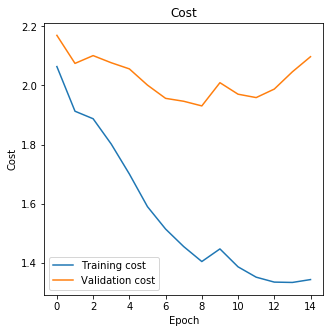

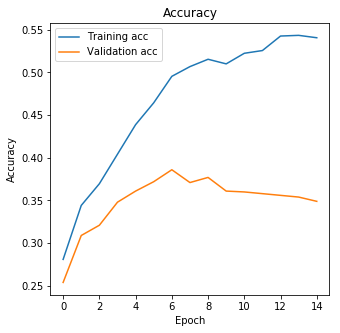

In [325]:
print(basicNetwork.networkInfo())

basicNetwork.computingCost = True
cost, acc = basicNetwork.feedForwardEvaluate(np.transpose(training_5000['images']), np.transpose(training_5000['label']))
print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = basicNetwork.feedForwardEvaluate(np.transpose(validate_1000['images']), np.transpose(validate_1000['label']))
print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = basicNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

basicNetwork.computingCost = False

plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )

In [327]:
# Perform the course search


COURSE_EPOCH = 5
COURSE_BATCH = 500
COURSE_MOMENTUM = 0.9


np.random.seed(5)

COURSE_LAMBDA = [0.3, 0.15, 0.03, 0.015, 0.003, 0.0015, 0.0003, 0.00015, 0.00003] 
COURSE_LEARNRATE = [0.3, 0.15, 0.03, 0.015, 0.003, 0.0015, 0.0003, 0.00015, 0.00003] 

training_5000 = {
        'images': training['images'][0:5000] ,
        'label': training['label'][0:5000], 
        'labelText': training['labelText'][0:5000] 
    }
validate_1000 = {
        'images': validate['images'][0:1000] ,
        'label': validate['label'][0:1000], 
        'labelText': validate['labelText'][0:1000] 
    }

String_Info = []
TrainCost_Info = []
TrainAcc_Info = []
ValidCost_Info = []
ValidAcc_Info = []
TestCost_Info = []
TestAcc_Info = []

for i in range(len(COURSE_LAMBDA)):
    for j in range(len(COURSE_LEARNRATE)):

        COURSE_NETWORK = Network(eta=COURSE_LEARNRATE[i], epoch=COURSE_EPOCH,batch=COURSE_BATCH, lambdaVal=COURSE_LAMBDA[j], momentum=COURSE_MOMENTUM);
        COURSE_NETWORK.putLayer(LayerObject("RELU",3072,50,True))
        COURSE_NETWORK.putLayer(LayerObject("RELU",50,30,True))
        COURSE_NETWORK.putLayer(LayerObject("SOFTMAX",30,10,False))
        print("Starting training on " + COURSE_NETWORK.networkInfo())
        accuracyTraining, accuracyValidation, costTraining, costValidation = train(training_5000, validate_1000, COURSE_NETWORK)
        
        # Append to array and get results
        String_Info.append(COURSE_NETWORK.networkInfo())

        COURSE_NETWORK.computingCost = True
        cost, acc = COURSE_NETWORK.feedForwardEvaluate(np.transpose(training_5000['images']), np.transpose(training_5000['label']))
        TrainCost_Info.append(cost)
        TrainAcc_Info.append(acc)
        
        #print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
        cost, acc = COURSE_NETWORK.feedForwardEvaluate(np.transpose(validate_1000['images']), np.transpose(validate_1000['label']))
        ValidCost_Info.append(cost)
        ValidAcc_Info.append(acc)
        
        #print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
        cost, acc = COURSE_NETWORK.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
        TestCost_Info.append(cost)
        TestAcc_Info.append(acc)
        #print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
        COURSE_NETWORK.computingCost = False
        print("DONE - info appended to array")


Starting training on Network Eta:0.3 epoch: 5 batch: 500 lambdaVal: 0.3 momentum: 0.9
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
DONE - info appended to array
Starting training on Network Eta:0.3 epoch: 5 batch: 500 lambdaVal: 0.15 momentum: 0.9
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
DONE - info appended to array
Starting training on Network Eta:0.3 epoch: 5 batch: 500 lambdaVal: 0.03 momentum: 0.9
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
DONE - info appended to array
Starting training on Network Eta:0.3 epoch: 5 batch: 500 lambdaVal: 0.015 momentum: 0.9
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
DONE - info appended to array
Starting training on Network Eta:0.3 epoch: 5 batch: 500 lambdaVal: 0.003 momentum: 0.9
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
DONE - info appended to array
Starting training on Network Eta:0.3 epoch: 5 batch: 500 lambdaVal: 0.0015 momentum: 0.9
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
DONE - info appended to a

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
DONE - info appended to array
Starting training on Network Eta:0.0015 epoch: 5 batch: 500 lambdaVal: 0.003 momentum: 0.9
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
DONE - info appended to array
Starting training on Network Eta:0.0015 epoch: 5 batch: 500 lambdaVal: 0.0015 momentum: 0.9
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
DONE - info appended to array
Starting training on Network Eta:0.0015 epoch: 5 batch: 500 lambdaVal: 0.0003 momentum: 0.9
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
DONE - info appended to array
Starting training on Network Eta:0.0015 epoch: 5 batch: 500 lambdaVal: 0.00015 momentum: 0.9
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
DONE - info appended to array
Starting training on Network Eta:0.0015 epoch: 5 batch: 500 lambdaVal: 3e-05 momentum: 0.9
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
DONE - info appended to array
Starting training on Network Eta:0.0003 epoch: 5 batch: 500 lambdaVal:

In [342]:
# Look at the found values
#print(String_Info)
TrainCost_Info.sort()
TrainAcc_Info.sort()

ValidCost_Info.sort()
ValidAcc_Info.sort()

TestCost_Info.sort()
TestAcc_Info.sort()

print(TrainCost_Info[0])
print(TrainCost_Info[1])
print(TrainCost_Info[2])

print(TrainAcc_Info[-1])
print(TrainAcc_Info[-2])
print(TrainAcc_Info[-3])

print(ValidCost_Info[0])
print(ValidCost_Info[1])
print(ValidCost_Info[2])

print(ValidAcc_Info[-1])
print(ValidAcc_Info[-2])
print(ValidAcc_Info[-3])

print(TestCost_Info[0])
print(TestCost_Info[1])
print(TestCost_Info[2])

print(TestAcc_Info[-1])
print(TestAcc_Info[-2])
print(TestAcc_Info[-3])

1.76984905215
1.77903651858
1.80760312771
0.4444
0.4418
0.4372
1.9132076791
1.9418583713
1.94867573138
0.377
0.373
0.372
1.91005976498
1.9243807677
1.92595580684
0.3693
0.3661
0.3656


In [345]:
# print the found indexes
print(String_Info[40])
print(String_Info[35])
print(String_Info[34]) 

Network Eta:0.003 epoch: 5 batch: 500 lambdaVal: 0.003 momentum: 0.9
Network Eta:0.015 epoch: 5 batch: 500 lambdaVal: 3e-05 momentum: 0.9
Network Eta:0.015 epoch: 5 batch: 500 lambdaVal: 0.00015 momentum: 0.9


In [ ]:
# Perform the fine search
import random

FINE_EPOCH = 10
FINE_BATCH = 500
FINE_MOMENTUM = 0.9


np.random.seed(5)

FINE_LAMBDA_MIN = 3e-05
FINE_LAMBDA_MAX = 0.003

FINE_LEARNRATE_MIN = 0.003
FINE_LEARNRATE_MAX = 0.015


training_7500 = {
        'images': training['images'][0:7500] ,
        'label': training['label'][0:7500], 
        'labelText': training['labelText'][0:7500] 
    }
validate_1000 = {
        'images': validate['images'][0:1000] ,
        'label': validate['label'][0:1000], 
        'labelText': validate['labelText'][0:1000] 
    }

# Not used though
FINE_String_Info = []
FINE_TrainCost_Info = []
FINE_TrainAcc_Info = []
FINE_ValidCost_Info = []
FINE_ValidAcc_Info = []
FINE_TestCost_Info = []
FINE_TestAcc_Info = []

numberOfTest = 50
for i in range(numberOfTest):
    
    FINE_LAMBDA = FINE_LAMBDA_MIN + (FINE_LAMBDA_MAX - FINE_LAMBDA_MIN)*random.random()
    FINE_ETA = FINE_LEARNRATE_MIN + (FINE_LEARNRATE_MAX - FINE_LEARNRATE_MIN)*random.random()
    
    COURSE_NETWORK = Network(eta=FINE_ETA, epoch=FINE_EPOCH,batch=FINE_BATCH, lambdaVal=FINE_LAMBDA, momentum=FINE_MOMENTUM);
    COURSE_NETWORK.putLayer(LayerObject("RELU",3072,50,True))
    COURSE_NETWORK.putLayer(LayerObject("RELU",50,30,True))
    COURSE_NETWORK.putLayer(LayerObject("SOFTMAX",30,10,False))
    print("Starting training on " + COURSE_NETWORK.networkInfo())
    accuracyTraining, accuracyValidation, costTraining, costValidation = train(training_5000, validate_1000, COURSE_NETWORK)

    # Append to array and get results
    String_Info.append(COURSE_NETWORK.networkInfo())

    COURSE_NETWORK.computingCost = True
    cost, acc = COURSE_NETWORK.feedForwardEvaluate(np.transpose(training_7500['images']), np.transpose(training_7500['label']))
    FINE_TrainCost_Info.append(cost)
    FINE_TrainAcc_Info.append(acc)

    cost, acc = COURSE_NETWORK.feedForwardEvaluate(np.transpose(validate_1000['images']), np.transpose(validate_1000['label']))
    FINE_ValidCost_Info.append(cost)
    FINE_ValidAcc_Info.append(acc)

    cost, acc = COURSE_NETWORK.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
    FINE_TestCost_Info.append(cost)
    FINE_TestAcc_Info.append(acc)
    print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
    COURSE_NETWORK.computingCost = False
    print("DONE - info appended to array")

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Done
Network Eta:0.010062184458341922 epoch: 30 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 53.26% and Cost: 1.4
Info on Validation data: Accuracy: 53.1% and Cost: 1.39
Info on Testing data: Accuracy: 44.89% and Cost: 1.65


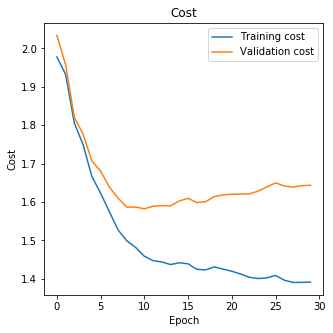

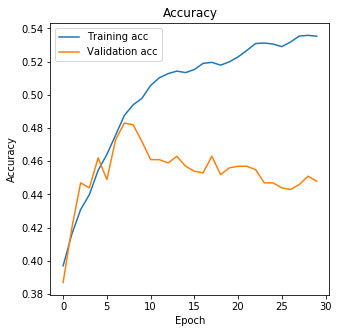

In [350]:
# Test the difference of batch normalization and not using it

np.random.seed(5)

bestNetwork = Network(eta=0.010062184458341922, epoch=30,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
bestNetwork.putLayer(LayerObject("RELU",3072,50,True))
bestNetwork.putLayer(LayerObject("RELU",50,30,True))
bestNetwork.putLayer(LayerObject("SOFTMAX",30,10,False))

accuracyTraining, accuracyValidation, costTraining, costValidation = train(training, validate, bestNetwork)

print(bestNetwork.networkInfo())

bestNetwork.computingCost = True
cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(training_5000['images']), np.transpose(training_5000['label']))
print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(validate_1000['images']), np.transpose(validate_1000['label']))
print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

bestNetwork.computingCost = False

plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )


In [42]:
# Info functions for report

def printInfo(training, validation, test, inputNodes, weights,bias,h_w,h_b, outputNodes, eta):
   
    probab = evaluateClassifier(np.transpose(training['images']),  weights,bias,h_w,h_b)
    finalAccuracy = computeAccuracy(probab, np.transpose(training['label']))
    finalCost = computeCost(probab, np.transpose(training['label']),  h_w, lambdaVal)
    print("Info on Training data: Accuracy: " + str(round(finalAccuracy*100,2)) + "% and Cost: " + str(round(finalCost,2) ))

    probab = evaluateClassifier(np.transpose(validation['images']),  weights,bias,h_w,h_b)
    val_finalCost = computeCost(probab, np.transpose(validation['label']),  h_w, lambdaVal)
    val_finalAccuracy = computeAccuracy(probab, np.transpose(validation['label']))
    print("Info on Validation data: Accuracy: " + str(round(val_finalAccuracy*100,2)) + "% and Cost: " + str(round(val_finalCost,2) ))

    probab = evaluateClassifier(np.transpose(test['images']),  weights,bias,h_w,h_b)
    test_finalCost = computeCost(probab, np.transpose(test['label']),  h_w, lambdaVal)
    test_finalAccuracy = computeAccuracy(probab, np.transpose(test['label']))
    print("Info on Testing data: Accuracy: " + str(round(test_finalAccuracy*100,2)) + "% and Cost: " + str(round(test_finalCost,2) ))

          
def plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation ):
    plt.plot(costTraining, label='Training cost')
    plt.plot(costValidation, label='Validation cost')
    plt.legend()
    
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('Cost')
    plt.show()
    plt.plot(accuracyTraining, label='Training acc')
    plt.plot(accuracyValidation, label='Validation acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.show()

def normalize(weightMatrix):
    maxVal = np.max(weightMatrix)
    minVal = np.min(weightMatrix)
    return (weightMatrix - minVal) / (maxVal - minVal)

def plotweights(W,label):
    for i, row in enumerate(W):
        imgNormalized = normalize(row) # ValueError: Floating point image RGB values must be in the 0..1 range.
        plt.subplot(5, 2, i+1)
        dispImg(imgNormalized, labels[i])
    plt.show()
    
# Run this cell after training to get the information about the trained network
def infoAboutNetwork():
    print("Info on network with lambda=" +str(lambdaVal) + " epochs=" + str(epoch) + " batch=" + str(batch) + " eta="+str(eta) )
    printInfo(training, validate, testing, inputNodes, inputWeights,inputBias, hiddenWeights, hiddenBias, outputNodes, eta)
    plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )
    plotweights(weights, labels)
    


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Done
Network Eta:0.010062184458341922 epoch: 10 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 35.44% and Cost: 1.84
Info on Validation data: Accuracy: 35.0% and Cost: 1.9
Info on Testing data: Accuracy: 33.95% and Cost: 1.87


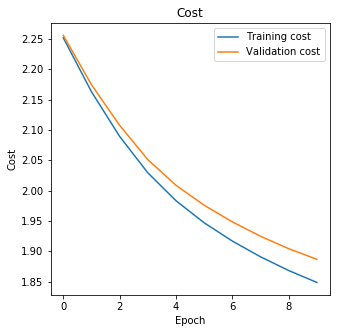

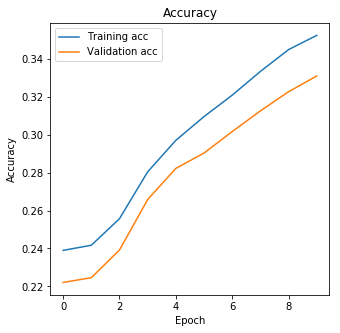

In [352]:
# Test the difference of batch normalization and not using it

np.random.seed(5)

bestNetwork = Network(eta=0.010062184458341922, epoch=10,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
bestNetwork.putLayer(LayerObject("RELU",3072,50,False))
#bestNetwork.putLayer(LayerObject("RELU",50,30,True))
bestNetwork.putLayer(LayerObject("SOFTMAX",50,10,False))

accuracyTraining, accuracyValidation, costTraining, costValidation = train(training, validate, bestNetwork)

print(bestNetwork.networkInfo())

bestNetwork.computingCost = True
cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(training_5000['images']), np.transpose(training_5000['label']))
print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(validate_1000['images']), np.transpose(validate_1000['label']))
print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

bestNetwork.computingCost = False

plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Done
Network Eta:0.00010062184458341922 epoch: 10 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 10.54% and Cost: 2.3
Info on Validation data: Accuracy: 11.0% and Cost: 2.3
Info on Testing data: Accuracy: 10.12% and Cost: 2.3


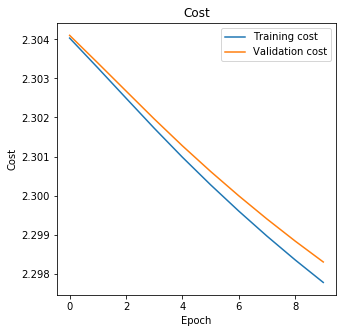

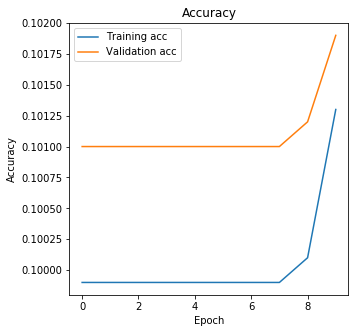

In [353]:
np.random.seed(5)

bestNetwork = Network(eta=0.010062184458341922/100, epoch=10,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
bestNetwork.putLayer(LayerObject("RELU",3072,50,False))
bestNetwork.putLayer(LayerObject("SOFTMAX",50,10,False))

accuracyTraining, accuracyValidation, costTraining, costValidation = train(training, validate, bestNetwork)

print(bestNetwork.networkInfo())

bestNetwork.computingCost = True
cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(training_5000['images']), np.transpose(training_5000['label']))
print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(validate_1000['images']), np.transpose(validate_1000['label']))
print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

bestNetwork.computingCost = False

plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )

Epoch: 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in greater


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Done
Network Eta:1.0062184458341923 epoch: 10 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 10.1% and Cost: nan
Info on Validation data: Accuracy: 10.2% and Cost: nan
Info on Testing data: Accuracy: 10.0% and Cost: nan


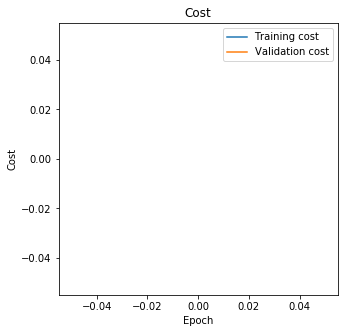

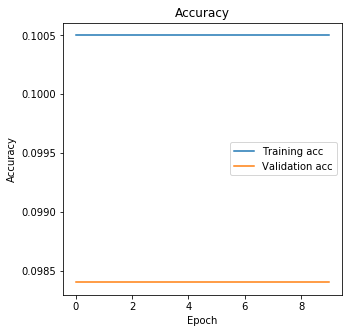

In [354]:
np.random.seed(5)

bestNetwork = Network(eta=0.010062184458341922*100, epoch=10,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
bestNetwork.putLayer(LayerObject("RELU",3072,50,False))
bestNetwork.putLayer(LayerObject("SOFTMAX",50,10,False))

accuracyTraining, accuracyValidation, costTraining, costValidation = train(training, validate, bestNetwork)

print(bestNetwork.networkInfo())

bestNetwork.computingCost = True
cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(training_5000['images']), np.transpose(training_5000['label']))
print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(validate_1000['images']), np.transpose(validate_1000['label']))
print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

bestNetwork.computingCost = False

plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Done
Network Eta:0.010062184458341922 epoch: 10 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 41.68% and Cost: 1.67
Info on Validation data: Accuracy: 39.7% and Cost: 1.8
Info on Testing data: Accuracy: 39.05% and Cost: 1.73


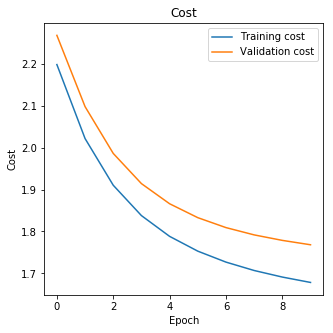

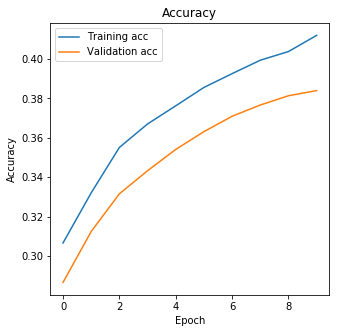

In [355]:
np.random.seed(5)

bestNetwork = Network(eta=0.010062184458341922, epoch=10,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
bestNetwork.putLayer(LayerObject("RELU",3072,50,True))
bestNetwork.putLayer(LayerObject("SOFTMAX",50,10,False))

accuracyTraining, accuracyValidation, costTraining, costValidation = train(training, validate, bestNetwork)

print(bestNetwork.networkInfo())

bestNetwork.computingCost = True
cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(training_5000['images']), np.transpose(training_5000['label']))
print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(validate_1000['images']), np.transpose(validate_1000['label']))
print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

bestNetwork.computingCost = False

plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Done
Network Eta:0.00010062184458341922 epoch: 10 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 28.82% and Cost: 2.09
Info on Validation data: Accuracy: 27.6% and Cost: 2.1
Info on Testing data: Accuracy: 27.16% and Cost: 2.1


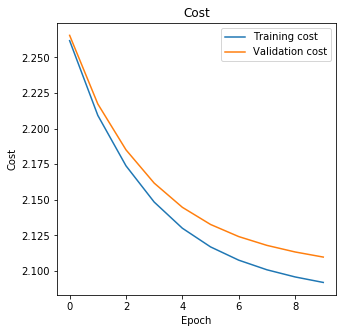

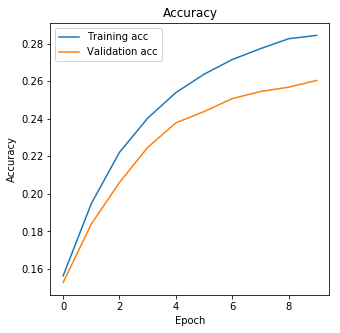

In [358]:
np.random.seed(5)

bestNetwork = Network(eta=0.010062184458341922/100, epoch=10,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
bestNetwork.putLayer(LayerObject("RELU",3072,50,True))
bestNetwork.putLayer(LayerObject("SOFTMAX",50,10,False))

accuracyTraining, accuracyValidation, costTraining, costValidation = train(training, validate, bestNetwork)

print(bestNetwork.networkInfo())

bestNetwork.computingCost = True
cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(training_5000['images']), np.transpose(training_5000['label']))
print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(validate_1000['images']), np.transpose(validate_1000['label']))
print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

bestNetwork.computingCost = False

plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Done
Network Eta:1.0062184458341923 epoch: 10 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 46.4% and Cost: 1.61
Info on Validation data: Accuracy: 39.9% and Cost: 1.83
Info on Testing data: Accuracy: 39.5% and Cost: 1.78


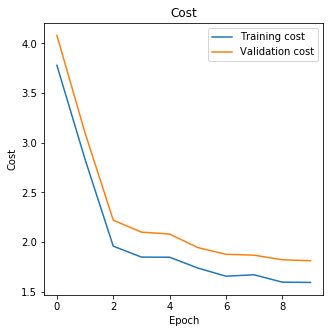

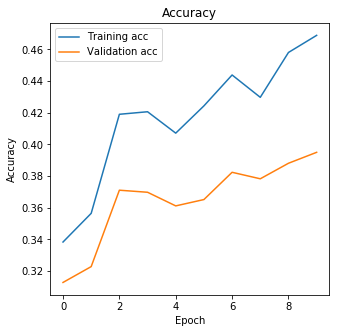

In [359]:
np.random.seed(5)

bestNetwork = Network(eta=0.010062184458341922*100, epoch=10,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
bestNetwork.putLayer(LayerObject("RELU",3072,50,True))
bestNetwork.putLayer(LayerObject("SOFTMAX",50,10,False))

accuracyTraining, accuracyValidation, costTraining, costValidation = train(training, validate, bestNetwork)

print(bestNetwork.networkInfo())

bestNetwork.computingCost = True
cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(training_5000['images']), np.transpose(training_5000['label']))
print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(validate_1000['images']), np.transpose(validate_1000['label']))
print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

bestNetwork.computingCost = False

plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )